<a href="https://colab.research.google.com/github/doanhieung/colab_notebooks/blob/main/Graph_based_Malware_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Note: This notebook was initially run on an Nvidia Geforce RTX 4070 machine for optimal performance.
# If you run it on Colab, uncomment and execute the following code in this cell to install required dependencies.

# import os
# import torch

# os.environ["TORCH"] = torch.__version__
# print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !mkdir model

### Explore Dataset

In [ ]:
from torch_geometric.datasets import MalNetTiny

# Load the dataset
train_dataset = MalNetTiny(root="data/MalNetTiny", split="train")
val_dataset = MalNetTiny(root="data/MalNetTiny", split="val")
test_dataset = MalNetTiny(root="data/MalNetTiny", split="test")

# Print a summary of the dataset
print("Train set:", train_dataset.get_summary())

Train set: MalNetTiny (#graphs=3500):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |   1504.7 |   2831.1 |
| std        |   1639.8 |   3191.9 |
| min        |      5   |      4   |
| quantile25 |    103   |     58   |
| median     |    987   |   1640   |
| quantile75 |   2453   |   4878   |
| max        |  14166   |  20096   |
+------------+----------+----------+


y_map = {'adware': 0, 'benign': 1, 'downloader': 2, 'trojan': 3, 'addisplay': 4}

In [ ]:
data = train_dataset[0]

# Gather some statistics about the first graph.
print(data)
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Data(edge_index=[2, 3576], y=[1], num_nodes=1679)
Number of nodes: 1679
Number of edges: 3576
Has isolated nodes: True
Has self-loops: True
Is undirected: False


In [ ]:
from torch_geometric.transforms import LocalDegreeProfile

transform = LocalDegreeProfile()

# Reload the dataset and add node features
train_dataset = MalNetTiny(root="data/MalNetTiny", split="train", transform=transform)
val_dataset = MalNetTiny(root="data/MalNetTiny", split="val", transform=transform)
test_dataset = MalNetTiny(root="data/MalNetTiny", split="test", transform=transform)

# Recheck the first data
data = train_dataset[0]
print(data)

Data(edge_index=[2, 3576], y=[1], num_nodes=1679, x=[1679, 5])


In [ ]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 128

# Create loaders for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
import torch
import time
import torch.nn.functional as F
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


def num_graphs(data):
    """
    Returns the number of graphs in a batch of data.
    """
    if hasattr(data, "num_graphs"):
        return data.num_graphs
    else:
        return data.x.size(0)


def train(model, optimizer, loader):
    """
    Train the model for one epoch.

    Args:
        model: The model to train.
        optimizer: The optimizer for updating model parameters.
        loader: DataLoader object providing batches of data for training.

    Returns:
        Average training loss.
    """
    model.train()

    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        data = data.to(device)
        out = model(data)
        loss = F.nll_loss(out, data.y.view(-1))
        loss.backward()
        total_loss += loss.item() * num_graphs(data)
        optimizer.step()
    return total_loss / len(loader.dataset)


def eval_acc(model, loader):
    """
    Evaluates the model to calculate accuracy over a dataset.

    Args:
        model: The model to evaluate.
        loader: DataLoader object providing batches of data.

    Returns:
        Accuracy over the dataset.
    """
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()
    return correct / len(loader.dataset)


def eval_loss(model, loader):
    """
    Evaluates the model to calculate the average loss over a dataset.

    Args:
        model: The model to evaluate.
        loader: DataLoader object providing batches of data.

    Returns:
        Average loss over the dataset.
    """
    model.eval()

    loss = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
        loss += F.nll_loss(out, data.y.view(-1), reduction="sum").item()
    return loss / len(loader.dataset)


def train_epochs(start, stop, model, optimizer, history):
    """
    Train the model over a specified range of epochs, and evaluate the model on validation data after each epoch.

    Args:
        start_epoch: Starting epoch number (inclusive).
        end_epoch: Ending epoch number (inclusive).
        model: The model to train.
        optimizer: Optimizer for updating the model parameters.
        history: A dictionary to store training loss, validation loss, and validation accuracy.

    Returns:
        Training time.
    """
    t0 = time.perf_counter()
    prev_eval_info = ""
    for epoch in range(start, stop + 1):
        history["train_loss"].append(train(model, optimizer, train_loader))
        history["val_loss"].append(eval_loss(model, val_loader))
        history["val_acc"].append(eval_acc(model, val_loader))

        if history["val_loss"][-1] == min(history["val_loss"]):
            torch.save(model.state_dict(), f"model/{model}.pth")

        eval_info = {
            "epoch": epoch,
            "train_loss": history["train_loss"][-1],
            "val_loss": history["val_loss"][-1],
            "val_acc": history["val_acc"][-1],
        }
        print(str(eval_info).ljust(len(prev_eval_info)), end="\r")
        prev_eval_info = str(eval_info)
    return int(time.perf_counter() - t0)


def draw_training_history(history):
    """
    Plots the training history, including loss and accuracy for both training and validation sets.

    Args:
        history: A dictionary containing training/validation loss and accuracy per epoch.
    """
    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plot training and validation loss
    ax1.plot(history["train_loss"], label="Training Loss", color="blue")
    ax1.plot(history["val_loss"], label="Validation Loss", color="orange")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="black")
    ax1.tick_params(axis="y", labelcolor="black")
    ax1.legend(loc="upper left")

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.plot(history["val_acc"], label="Validation Accuracy", color="green", ls=":")
    ax2.set_ylabel("Accuracy", color="black")
    ax2.tick_params(axis="y", labelcolor="black")

    # Add title and show the plot
    plt.title("Training History")
    fig.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


def test(model, loader):
    """
    Test the model on the test dataset and print the classification report.

    Args:
        model: The trained GCN model to evaluate.
        loader: DataLoader object providing batches of data from the test set.

    Returns:
        A classification report showing precision, recall, and F1-score for each class.
    """
    model.eval()
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(1)[1]
        y_true.extend(data.y.view(-1).tolist())
        y_pred.extend(pred.tolist())
    print(classification_report(y_pred, y_true, digits=4))

### Graph Convolutional Network

#### Train

In [ ]:
from torch.nn import Linear

from torch_geometric.nn import GCNConv, global_max_pool, JumpingKnowledge


class GCNWithJK(torch.nn.Module):
    """
    Graph Convolutional Network with Jumping Knowledge.

    Args:
        dataset: The dataset object, used to define input and output sizes.
        num_layers: Number of graph convolutional layers.
        hidden: Number of hidden units in each layer.
        mode: The aggregation scheme to use (default to concatenation - "cat").

    Methods:
        reset_parameters: Resets the parameters of the model.
        forward: Defines the forward pass of the model.
    """

    def __init__(self, dataset, num_layers, hidden, mode="cat"):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden, hidden))
        self.jump = JumpingKnowledge(mode)
        if mode == "cat":
            self.lin = Linear(num_layers * hidden, dataset.num_classes)
        else:
            self.lin = Linear(hidden, dataset.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.jump.reset_parameters()
        self.lin.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        xs = [x]
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
            xs += [x]
        x = self.jump(xs)
        x = global_max_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__

In [ ]:
from torch.optim import Adam

# Create model
model = GCNWithJK(train_dataset, num_layers=6, hidden=128)
model.to(device).reset_parameters()

optimizer = Adam(model.parameters())

if torch.cuda.is_available():
    torch.cuda.synchronize()

# Prepare history tracking
history = {"train_loss": [], "val_loss": [], "val_acc": []}

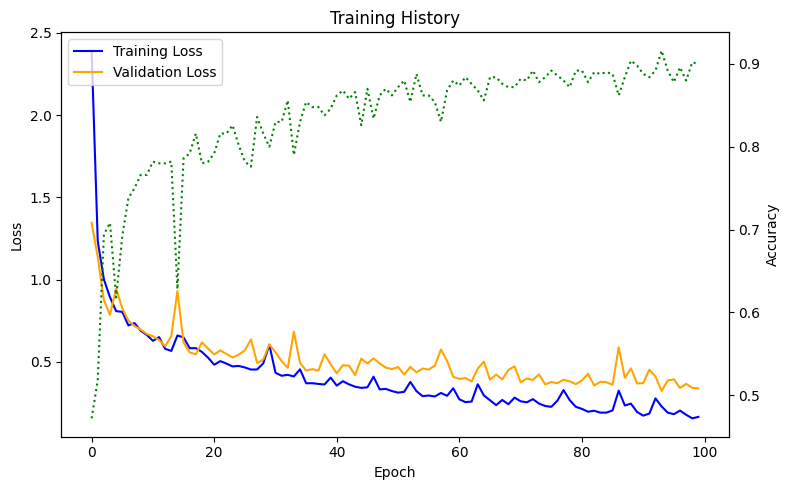

Best val loss: 0.32252924728393556
Training time: 371 (s)


In [ ]:
# Train the model for epochs
training_time = train_epochs(1, 100, model, optimizer, history)

draw_training_history(history)
print("Best val loss:", min(history["val_loss"]))
print("Training time:", training_time, "(s)")

#### Test

In [ ]:
# Load and test the best model
print(model)
model.load_state_dict(torch.load(f"model/{model}.pth", weights_only=True))
test(model, test_loader)

GCNWithJK
              precision    recall  f1-score   support

           0     0.9350    0.8990    0.9167       208
           1     0.8050    0.8090    0.8070       199
           2     0.9950    0.9851    0.9900       202
           3     0.8100    0.9257    0.8640       175
           4     0.9450    0.8750    0.9087       216

    accuracy                         0.8980      1000
   macro avg     0.8980    0.8988    0.8973      1000
weighted avg     0.9015    0.8980    0.8987      1000



### GraphSAGE

#### Train

In [ ]:
from torch_geometric.nn import JumpingKnowledge, SAGEConv


class GraphSAGEWithJK(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden, mode="cat"):
        super().__init__()
        self.conv1 = SAGEConv(dataset.num_features, hidden)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden, hidden))
        self.jump = JumpingKnowledge(mode)
        if mode == "cat":
            self.lin = Linear(num_layers * hidden, dataset.num_classes)
        else:
            self.lin = Linear(hidden, dataset.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.jump.reset_parameters()
        self.lin.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        xs = [x]
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
            xs += [x]
        x = self.jump(xs)
        x = global_max_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__

In [ ]:
from torch.optim import Adam

# Create model
model = GraphSAGEWithJK(train_dataset, num_layers=6, hidden=128)
model.to(device).reset_parameters()

optimizer = Adam(model.parameters())

if torch.cuda.is_available():
    torch.cuda.synchronize()

# Prepare history tracking
history = {"train_loss": [], "val_loss": [], "val_acc": []}

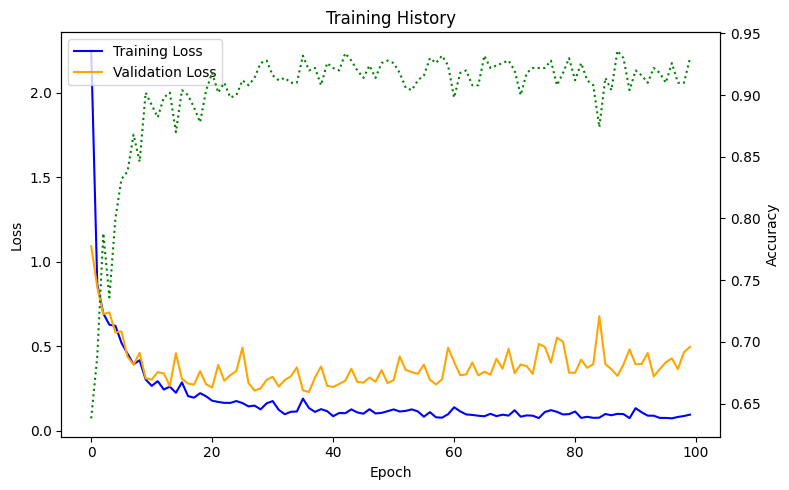

Best val loss: 0.22937039566040038
Training time: 320 (s)


In [ ]:
# Train the model for epochs
training_time = train_epochs(1, 100, model, optimizer, history)

draw_training_history(history)
print("Best val loss:", min(history["val_loss"]))
print("Training time:", training_time, "(s)")

#### Test

In [ ]:
# Load and test the best model
print(model)
model.load_state_dict(torch.load(f"model/{model}.pth", weights_only=True))
test(model, test_loader)

GraphSAGEWithJK
              precision    recall  f1-score   support

           0     0.9500    0.9360    0.9429       203
           1     0.8900    0.8091    0.8476       220
           2     0.9950    0.9851    0.9900       202
           3     0.8350    0.9278    0.8789       180
           4     0.9450    0.9692    0.9570       195

    accuracy                         0.9230      1000
   macro avg     0.9230    0.9254    0.9233      1000
weighted avg     0.9242    0.9230    0.9227      1000



### Graph Isomorphism Network

#### Train

In [ ]:
import torch.nn.functional as F
from torch.nn import BatchNorm1d as BN
from torch.nn import Linear, ReLU, Sequential

from torch_geometric.nn import GINConv, JumpingKnowledge, global_max_pool


class GINWithJK(torch.nn.Module):
    def __init__(self, dataset, num_layers, hidden, mode="cat"):
        super().__init__()
        self.conv1 = GINConv(
            Sequential(
                Linear(dataset.num_features, hidden),
                ReLU(),
                BN(hidden),
                Linear(hidden, hidden),
                ReLU(),
                BN(hidden),
            ),
            train_eps=True,
        )
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(
                GINConv(
                    Sequential(
                        Linear(hidden, hidden),
                        ReLU(),
                        BN(hidden),
                        Linear(hidden, hidden),
                        ReLU(),
                        BN(hidden),
                    ),
                    train_eps=True,
                )
            )
        self.jump = JumpingKnowledge(mode)
        if mode == "cat":
            self.lin = Linear(num_layers * hidden, dataset.num_classes)
        else:
            self.lin = Linear(hidden, dataset.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.jump.reset_parameters()
        self.lin.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        xs = [x]
        for conv in self.convs:
            x = conv(x, edge_index)
            xs += [x]
        x = self.jump(xs)
        x = global_max_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__

In [ ]:
from torch.optim import Adam

# Create model
model = GINWithJK(train_dataset, num_layers=6, hidden=128)
model.to(device).reset_parameters()

optimizer = Adam(model.parameters())

if torch.cuda.is_available():
    torch.cuda.synchronize()

# Prepare history tracking
history = {"train_loss": [], "val_loss": [], "val_acc": []}

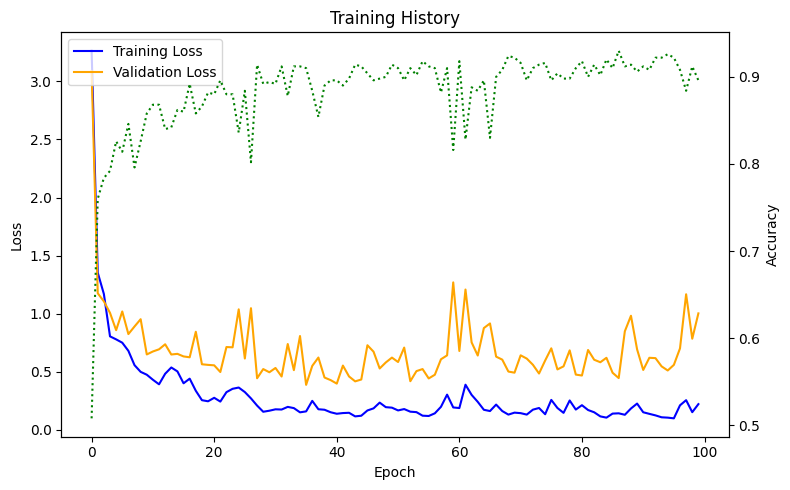

Best val loss: 0.38784481430053713
Training time: 410 (s)


In [ ]:
# Train the model for epochs
training_time = train_epochs(1, 100, model, optimizer, history)

draw_training_history(history)
print("Best val loss:", min(history["val_loss"]))
print("Training time:", training_time, "(s)")

#### Test

In [ ]:
# Load and test the best model
print(model)
model.load_state_dict(torch.load(f"model/{model}.pth", weights_only=True))
test(model, test_loader)

GINWithJK
              precision    recall  f1-score   support

           0     0.9350    0.9078    0.9212       206
           1     0.8800    0.7753    0.8244       227
           2     0.9850    0.9850    0.9850       200
           3     0.8050    0.9415    0.8679       171
           4     0.9450    0.9643    0.9545       196

    accuracy                         0.9100      1000
   macro avg     0.9100    0.9148    0.9106      1000
weighted avg     0.9122    0.9100    0.9094      1000

